# FINAL PROJECT: FINAL STACKING SOLUTION LGBM+EN>>LR

You can find all the data in `../readonly/final_project_data` folder or download it from [Kaggle](https://inclass.kaggle.com/c/competitive-data-science-final-project) if you are solving locally. 

**Good luck!**

# Competition description

This challenge serves as final project for the _"How to win a data science competition"_ Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - __1C Company__.

We are asking you to __predict total sales for every product and store in the next month__. By solving this competition you will be able to apply and enhance your data science skills.

### Submission File

For each id in the test set, you must predict a total number of sales. The file should contain a header and have the following format:

`ID,item_cnt_month
0,0.5
1,0.5
2,0.5
3,0.5
etc.`

### Team Limits

Three individuals.

### Submission Limits

You may submit a maximum of 5 entries per day (10 for Coursera).

### Metric

Submissions are evaluated by root mean squared error (__RMSE__). True target values are clipped into [0,20] range.

In [1]:
target_range = [0, 20]

### Leaderboard
By now lowest RMSE in PL is: `0.79215`
with `210` submissions

# Imports

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML

import os, gc, math

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline 

from itertools import product

import lightgbm as lgb
from sklearn import feature_extraction
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import scipy.sparse 

from tqdm import tqdm, tqdm_notebook
tqdm.monitor_interval = 0

import data
from data import index_cols, index_cols_shop, future_index_cols
import features
import tools
import models
from models import rmse_score

%load_ext autoreload
%autoreload 2

In [3]:
import sklearn
for p in [np, pd, sklearn, scipy]:
    print (p.__name__, p.__version__)

numpy 1.17.0
pandas 0.25.0
sklearn 0.21.3
scipy 1.3.0


# LOAD FEATURES
Preprocessed, from disk.

In [4]:
all_data = features.load_features()

# Check
data.inspect_dataframe('ALL_DATA', all_data)


ALL_DATA (6639294, 44)
shop_id                       int32
item_id                       int32
date_block_num                int32
target                      float32
revenue                     float32
target_shop                 float32
revenue_per_shop            float32
target_item                 float32
revenue_per_item            float32
item_category_id              int32
target_category             float32
revenue_per_category        float32
target_item_price           float32
item_category_id_enc        float32
target_lag_1                float32
target_lag_2                float32
target_lag_3                float32
target_lag_4                float32
target_lag_5                float32
target_lag_12               float32
target_shop_lag_1           float32
target_shop_lag_2           float32
target_shop_lag_3           float32
target_shop_lag_4           float32
target_shop_lag_5           float32
target_shop_lag_12          float32
target_item_lag_1           float32
targ

,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,...,target_category_lag_3,target_category_lag_4,target_category_lag_5,target_category_lag_12,target_item_price_lag_1,target_item_price_lag_2,target_item_price_lag_3,target_item_price_lag_4,target_item_price_lag_5,target_item_price_lag_12
4488756,2,27,12,0.0,0.0,890.0,1032722.0,1.0,998.0,19,...,14113.0,18932.0,10488.0,8983.0,1048.000000,1198.000000,942.266663,1198.0,1198.000000,2325.0
4488757,2,30,12,0.0,0.0,890.0,1032722.0,58.0,9802.0,40,...,24173.0,23348.0,24130.0,0.0,167.330856,165.217392,205.524994,399.0,384.894745,0.0
4488758,2,31,12,0.0,0.0,890.0,1032722.0,15.0,7485.0,37,...,6950.0,7659.0,8680.0,0.0,499.000000,488.377777,543.528015,699.0,688.400024,0.0


,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,...,target_category_lag_3,target_category_lag_4,target_category_lag_5,target_category_lag_12,target_item_price_lag_1,target_item_price_lag_2,target_item_price_lag_3,target_item_price_lag_4,target_item_price_lag_5,target_item_price_lag_12
11128047,59,22164,34,0.0,0.0,0.0,0.0,0.0,0.0,37,...,3426.0,3291.0,3756.0,0.0,549.000000,549.0,631.5,699.0,699.000000,0.0
11128048,59,22166,34,0.0,0.0,0.0,0.0,0.0,0.0,54,...,264.0,276.0,292.0,305.0,150.000000,150.0,150.0,150.0,150.000000,150.0
11128049,59,22167,34,0.0,0.0,0.0,0.0,0.0,0.0,49,...,571.0,669.0,699.0,760.0,293.895935,299.0,299.0,299.0,294.636353,299.0


# Data split

The dataset has a timeline, get last month of train as validation data.

And the month=34 is the X_test for final submission.

In [5]:
X_train, y_train, dates_train, X_val, y_val, dates_val, X_test, y_test, dates_test = data.split_and_dates(all_data)

Test data is where date_block_num=34
Validation data is where date_block_num=33

fit_cols: ['item_category_id', 'item_category_id_enc', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_4', 'target_lag_5', 'target_lag_12', 'target_shop_lag_1', 'target_shop_lag_2', 'target_shop_lag_3', 'target_shop_lag_4', 'target_shop_lag_5', 'target_shop_lag_12', 'target_item_lag_1', 'target_item_lag_2', 'target_item_lag_3', 'target_item_lag_4', 'target_item_lag_5', 'target_item_lag_12', 'target_category_lag_1', 'target_category_lag_2', 'target_category_lag_3', 'target_category_lag_4', 'target_category_lag_5', 'target_category_lag_12', 'target_item_price_lag_1', 'target_item_price_lag_2', 'target_item_price_lag_3', 'target_item_price_lag_4', 'target_item_price_lag_5', 'target_item_price_lag_12'] 32 

train validation test total
6186922 238172 214200 6639294
6186922 238172 214200 6639294


# MODEL
The stacking is the selected approach, combine three 1-st level models (NN, EN and LGB) with a 2-nd level simple model (LinearRegressor)

## 1. Fit first level models

The features will be created using the lectures f) KFold scheme in ime series, with T=1_month and M=Total_months-6.

Split the train data into chunks of duration T. Select first M chunks.
Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. 

After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.

Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.

### 1.1 Train meta features
The six last months are the chunks for folding.

In [6]:
last_blocks = [27, 28, 29, 30, 31, 32]
dates_train_level2 = dates_train[dates_train.isin(last_blocks)]

In [8]:
# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(last_blocks)]

# And here we create 2nd level feature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 3])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in last_blocks:
    
    print("\nBlock",cur_block_num,"\n")

        # define the block training data

    X_block_train = X_train.loc[dates_train <  cur_block_num]
    y_block_train = y_train[dates_train < cur_block_num]
    X_block_val = X_train[dates_train == cur_block_num]
    y_block_val = y_train[dates_train == cur_block_num]
    
        # fit models for data block and get predictions
        
    nn_model = models.modelNNR(target_range)
    nn_model.fit_early(X_block_train, y_block_train, X_block_val, y_block_val)
    nn_model.scoring(X_block_val, y_block_val, X_block_train, y_block_train)
    pred_nn = nn_model.predict(X_block_val)

    en_model = models.modelEN(target_range)
    en_model.fit(X_block_train,y_block_train)
    en_model.scoring(X_block_val, y_block_val, X_block_train, y_block_train)
    pred_en = en_model.predict(X_block_val)

    lgb_model = models.modelLGB(target_range)
    lgb_model.fit(X_block_train, y_block_train)
    lgb_model.scoring(X_block_val, y_block_val, X_block_train, y_block_train)
    pred_lgb = lgb_model.predict(X_block_val)

    print("")
    
        # store predictions in X_train_level2
    del(nn_model)
    del(en_model)
    del(lgb_model)
    gc.collect()
    X_train_level2[dates_train_level2 == cur_block_num] = np.c_[pred_nn, pred_en, pred_lgb] 
    
print(X_train_level2.shape)
print(X_train_level2[:3])


Block 27 

model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 200, 'n_hidden2': 100, 'dropout': 0.2, 'optim_type': 'adam', 'learning_rate': 0.0001, 'batch_size': 1024}
2019-08-06 18:09:00.127254
 ** predictions clipping to [0, 20]
 ** predictions clipping to [0, 20]

2019-08-06 18:09:02 ---- START training
. . . . . . . . . . . . . . . . . . . . . . . . . . . . 
2019-08-06 18:26:33 *** Early stop at epoch 26/99, best_ValLoss = 0.8815
2019-08-06 18:26:33 --- DONE Epoch = 26/99 AvgLoss = 0.9147 ValLoss = 0.8819

elapsed training time: 1053.92
 ** predictions clipping to [0, 20]
elapsed infer time: 18.27
 ** predictions clipping to [0, 20]
Train RMSE for NNR is 0.966743
 ** predictions clipping to [0, 20]
elapsed infer time: 0.32
 ** predictions clipping to [0, 20]
Dev RMSE for NNR is 0.938292
 ** predictions clipping to [0, 20]
elapsed infer time: 0.16
2019-08-06 18:26:53.038826
elapsed training time: 17.14
 ** predictions clipping to [0, 20]
elapsed infer time: 2.12
 ** prediction

117


Block 28 

model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 200, 'n_hidden2': 100, 'dropout': 0.2, 'optim_type': 'adam', 'learning_rate': 0.0001, 'batch_size': 1024}
2019-08-06 18:30:34.402634
 ** predictions clipping to [0, 20]
 ** predictions clipping to [0, 20]

2019-08-06 18:30:36 ---- START training
. . . . . . . . . . . . . . . . . . . . . . . . . 
2019-08-06 18:46:56 *** Early stop at epoch 23/99, best_ValLoss = 0.9330
2019-08-06 18:46:56 --- DONE Epoch = 23/99 AvgLoss = 0.9247 ValLoss = 0.9333

elapsed training time: 982.05
 ** predictions clipping to [0, 20]
elapsed infer time: 20.83
 ** predictions clipping to [0, 20]
Train RMSE for NNR is 1.028612
 ** predictions clipping to [0, 20]
elapsed infer time: 0.30
 ** predictions clipping to [0, 20]
Dev RMSE for NNR is 0.965916
 ** predictions clipping to [0, 20]
elapsed infer time: 0.14
2019-08-06 18:47:17.969459
elapsed training time: 20.63
 ** predictions clipping to [0, 20]
elapsed infer time: 2.28
 ** predictions clipp

117


Block 29 

model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 200, 'n_hidden2': 100, 'dropout': 0.2, 'optim_type': 'adam', 'learning_rate': 0.0001, 'batch_size': 1024}
2019-08-06 18:51:08.594686
 ** predictions clipping to [0, 20]
 ** predictions clipping to [0, 20]

2019-08-06 18:51:10 ---- START training
. . . . . . . . . . . . 
2019-08-06 18:59:00 *** Early stop at epoch 10/99, best_ValLoss = 0.8685
2019-08-06 18:59:00 --- DONE Epoch = 10/99 AvgLoss = 1.0057 ValLoss = 0.8724

elapsed training time: 471.97
 ** predictions clipping to [0, 20]
elapsed infer time: 19.49
 ** predictions clipping to [0, 20]
Train RMSE for NNR is 1.025248
 ** predictions clipping to [0, 20]
elapsed infer time: 0.28
 ** predictions clipping to [0, 20]
Dev RMSE for NNR is 0.931919
 ** predictions clipping to [0, 20]
elapsed infer time: 0.14
2019-08-06 18:59:20.727795
elapsed training time: 23.97
 ** predictions clipping to [0, 20]
elapsed infer time: 2.31
 ** predictions clipping to [0, 20]
Train RMSE 

117


Block 30 

model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 200, 'n_hidden2': 100, 'dropout': 0.2, 'optim_type': 'adam', 'learning_rate': 0.0001, 'batch_size': 1024}
2019-08-06 19:03:29.383480
 ** predictions clipping to [0, 20]
 ** predictions clipping to [0, 20]

2019-08-06 19:03:31 ---- START training
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
2019-08-06 19:27:48 *** Early stop at epoch 32/99, best_ValLoss = 0.5920
2019-08-06 19:27:48 --- DONE Epoch = 32/99 AvgLoss = 0.8673 ValLoss = 0.5928

elapsed training time: 1459.61
 ** predictions clipping to [0, 20]
elapsed infer time: 21.84
 ** predictions clipping to [0, 20]
Train RMSE for NNR is 0.945006
 ** predictions clipping to [0, 20]
elapsed infer time: 0.30
 ** predictions clipping to [0, 20]
Dev RMSE for NNR is 0.767640
 ** predictions clipping to [0, 20]
elapsed infer time: 0.14
2019-08-06 19:28:11.557413
elapsed training time: 24.51
 ** predictions clipping to [0, 20]
elapsed infer time: 2.44
 *

117


Block 31 

model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 200, 'n_hidden2': 100, 'dropout': 0.2, 'optim_type': 'adam', 'learning_rate': 0.0001, 'batch_size': 1024}
2019-08-06 19:32:23.136777
 ** predictions clipping to [0, 20]
 ** predictions clipping to [0, 20]

2019-08-06 19:32:25 ---- START training
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
2019-08-06 19:55:11 *** Early stop at epoch 29/99, best_ValLoss = 0.7269
2019-08-06 19:55:11 --- DONE Epoch = 29/99 AvgLoss = 0.8645 ValLoss = 0.7275

elapsed training time: 1368.13
 ** predictions clipping to [0, 20]
elapsed infer time: 26.06
 ** predictions clipping to [0, 20]
Train RMSE for NNR is 0.964769
 ** predictions clipping to [0, 20]
elapsed infer time: 0.30
 ** predictions clipping to [0, 20]
Dev RMSE for NNR is 0.851465
 ** predictions clipping to [0, 20]
elapsed infer time: 0.14
2019-08-06 19:55:38.022514
elapsed training time: 23.21
 ** predictions clipping to [0, 20]
elapsed infer time: 2.50
 ** pred

117


Block 32 

model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 200, 'n_hidden2': 100, 'dropout': 0.2, 'optim_type': 'adam', 'learning_rate': 0.0001, 'batch_size': 1024}
2019-08-06 19:59:57.033484
 ** predictions clipping to [0, 20]
 ** predictions clipping to [0, 20]

2019-08-06 19:59:59 ---- START training
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
2019-08-06 20:22:05 *** Early stop at epoch 27/99, best_ValLoss = 0.9256
2019-08-06 20:22:05 --- DONE Epoch = 27/99 AvgLoss = 0.8575 ValLoss = 0.9290

elapsed training time: 1328.43
 ** predictions clipping to [0, 20]
elapsed infer time: 37.08
 ** predictions clipping to [0, 20]
Train RMSE for NNR is 0.968727
 ** predictions clipping to [0, 20]
elapsed infer time: 0.35
 ** predictions clipping to [0, 20]
Dev RMSE for NNR is 0.960760
 ** predictions clipping to [0, 20]
elapsed infer time: 0.14
2019-08-06 20:22:43.340956
elapsed training time: 24.53
 ** predictions clipping to [0, 20]
elapsed infer time: 2.59
 ** predicti

117

(1376192, 3)
[[0.39464712 0.15501052 0.4808617 ]
 [0.39464712 0.15501052 0.4808617 ]
 [0.16550441 0.0801465  0.06196005]]


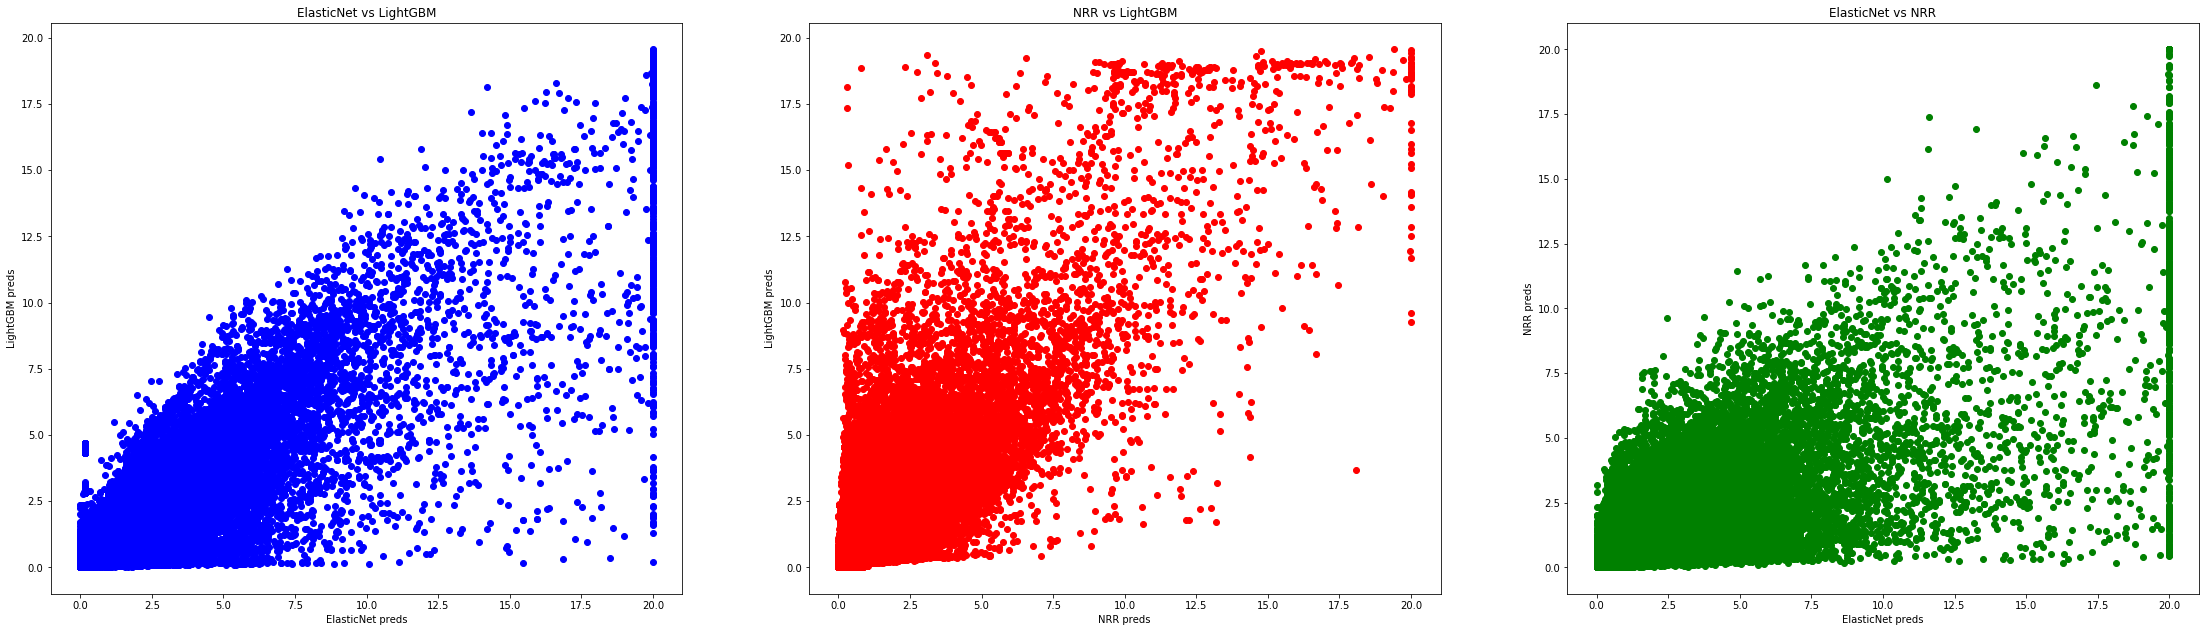

In [15]:
# Check correlation of 1st level models
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

def do_scatter(ax,X,Y,x_name,y_name,color):
    ax.scatter(X,Y,color=color)
    ax.set_xlabel(x_name+" preds")
    ax.set_ylabel(y_name+" preds")
    ax.set_title(x_name+" vs "+y_name)

do_scatter(ax1,X_train_level2[:,1],X_train_level2[:,2],'ElasticNet','LightGBM','blue')
do_scatter(ax2,X_train_level2[:,0],X_train_level2[:,2],'NRR','LightGBM','red')
do_scatter(ax3,X_train_level2[:,1],X_train_level2[:,0],'ElasticNet','NRR','green')

fig.set_size_inches(38.5, 10.5)
plt.show()

In [21]:
filename = 'features/X_train_level2_nn_en_lgb.pkl'
pickle.dump(X_train_level2, open(filename, 'wb'))
#X_train_level2 = pickle.load(open(filename, 'rb'))

### 1.2 Validation meta features
Create meta features for the validation data (last month of train data).

In [25]:
   # fit models and create the predictions

nn_model = models.modelNNR(target_range)
nn_model.fit_early(X_train, y_train, X_val, y_val) 
nn_model.scoring(X_val, y_val, X_train, y_train)
pred_nn = nn_model.predict(X_val)
print("")

en_model = models.modelEN(target_range)
en_model.fit(X_train, y_train)
en_model.scoring(X_val, y_val, X_train, y_train)
pred_en = en_model.predict(X_val)
print("")

lgb_model = models.modelLGB(target_range)
lgb_model.fit(X_train, y_train)
lgb_model.scoring(X_val, y_val, X_train, y_train)
pred_lgb = lgb_model.predict(X_val)
print("")

     # concatenate predictions to get the meta features

X_val_level2 = np.c_[pred_nn, pred_en, pred_lgb] 
print(X_val_level2.shape)
print(X_val_level2[:3])

model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 200, 'n_hidden2': 100, 'dropout': 0.2, 'optim_type': 'adam', 'learning_rate': 0.0001, 'batch_size': 1024}
2019-08-06 20:40:11.053833
 ** predictions clipping to [0, 20]
 ** predictions clipping to [0, 20]

2019-08-06 20:40:15 ---- START training
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
2019-08-06 21:06:06 *** Early stop at epoch 30/99, best_ValLoss = 0.9419
2019-08-06 21:06:06 --- DONE Epoch = 30/99 AvgLoss = 0.8463 ValLoss = 0.9427

elapsed training time: 1555.37
 ** predictions clipping to [0, 20]
elapsed infer time: 37.82
 ** predictions clipping to [0, 20]
Train RMSE for NNR is 0.924869
 ** predictions clipping to [0, 20]
elapsed infer time: 0.53
 ** predictions clipping to [0, 20]
Dev RMSE for NNR is 0.968987
 ** predictions clipping to [0, 20]
elapsed infer time: 0.12

2019-08-06 21:06:45.228198
elapsed training time: 26.35
 ** predictions clipping to [0, 20]
elapsed infer time: 2.76
 ** predictions c

In [26]:
filename = 'features/X_val_level2_nn_en_lgb.pkl'
pickle.dump(X_val_level2, open(filename, 'wb'))
#X_val_level2 = pickle.load(open(filename, 'rb'))

## 2. Stack the models

Whe have to find a 2-nd level meta-model that fits ok to the 1-st level meta-features.

### 2.1. Linear mix (THE BEST ???)

Try a simple linear convex mix:

        mix=α⋅neuralnet_prediction+ß·elasticnet_prediction+(1−α-ß)⋅lgb_prediction
 
And fit it finding an optimal α and ß whose addition is equal to one.

In [31]:
# Fit to the optimal alpha and beta with a grid search

alphas_to_try = np.linspace(0, 1, 101)

def lcmix_predict(X, alpha, beta):
    return alpha*X[:,0] + beta*X[:,1] + (1-alpha-beta)*X[:,2]

best_alpha, best_beta = -1, -1
r2_train_simple_mix = -1e10
for alpha in tqdm_notebook(alphas_to_try):
    betas_to_try = np.linspace(0,1-alpha,101)
    for beta in betas_to_try:
        lcmix_preds = lcmix_predict(X_train_level2, alpha, beta)
        r2 = r2_score(y_train_level2, lcmix_preds)
        if r2 > r2_train_simple_mix:
            best_alpha, best_beta = alpha, beta
            r2_train_simple_mix = r2

print('Best alpha: %f and beta: %f; Corresponding r2 score on train: %f' % (best_alpha, best_beta, r2_train_simple_mix))


Best alpha: 0.000000 and beta: 0.160000; Corresponding r2 score on train: 0.082464


If alpha is zero, means that the NN is **not improving** the ensemble...

In [33]:
# The score that should be near to the one in the LeaderBoard (I hope so)
lcmix_preds = lcmix_predict(X_val_level2, best_alpha, best_beta)
print('Dev R-squared for simple mix is %f' % r2_score(y_val, lcmix_preds))
print('Dev RMSE for simple mix is %f' %  rmse_score(y_val.clip(*target_range), lcmix_preds))

Dev R-squared for simple mix is 0.048726
Dev RMSE for simple mix is 0.928142


### 2.2 Linear regression
Try a Linear Regressor to stack ElasticNet and LightGBM together.

In [34]:
# Create model
lr_model = models.modelLR(target_range)
lr_model.fit(pd.DataFrame(X_train_level2), y_train_level2)

# The score that should be near to the one in the LeaderBoard (I hope so)
lr_model.scoring(pd.DataFrame(X_val_level2), y_val, pd.DataFrame(X_train_level2), y_train_level2)

2019-08-07 02:39:31.463268
elapsed training time: 0.20
 ** predictions clipping to [0, 20]
elapsed infer time: 0.07
 ** predictions clipping to [0, 20]
Train RMSE for LR is 0.971272
 ** predictions clipping to [0, 20]
elapsed infer time: 0.01
 ** predictions clipping to [0, 20]
Dev RMSE for LR is 1.134595


### 2.3 Decission tree
Try a simple decission tree.

In [35]:
# Create model
dtr_model = models.modelDTR(target_range)
dtr_model.fit(pd.DataFrame(X_train_level2), y_train_level2)

# The score that should be near to the one in the LeaderBoard (I hope so)
dtr_model.scoring(pd.DataFrame(X_val_level2), y_val, pd.DataFrame(X_train_level2), y_train_level2)

2019-08-07 02:40:14.349033
 ** predictions clipping to [0, 20]
elapsed training time: 13.06
 ** predictions clipping to [0, 20]
elapsed infer time: 0.62
 ** predictions clipping to [0, 20]
Train RMSE for DecissionTree is 0.460931
 ** predictions clipping to [0, 20]
elapsed infer time: 0.11
 ** predictions clipping to [0, 20]
Dev RMSE for DecissionTree is 1.166272


## 3. Predictions for submission
Fit the 1-st models with all available labeled data and predict on test data with the 2-nd model (linear mix, the best one) for later submission.

In [45]:
import models

In [ ]:
del(nn_model)
del(en_model)
del(lgb_model)
gc.collect()

In [46]:
    # prepare all data

X_all = X_train.append(X_val)
y_all = np.concatenate([y_train, y_val])
print(len(X_all),len(y_all),len(X_test),'\n')

    # fit 1-st level models and create the predictions

nn_model = models.modelNNR(target_range)
nn_model.fit(X_all,y_all)                  # No early stopping (no validation data), fit to 36 epochs
pred_nn = nn_model.predict(X_test)
print(len(pred_nn),"\n")

en_model = models.modelEN(target_range)
en_model.fit(X_all,y_all)
pred_en = en_model.predict(X_test)
print(len(pred_en),"\n")

lgb_model = models.modelLGB(target_range)
lgb_model.fit(X_all,y_all)
pred_lgb = lgb_model.predict(X_test)
print(len(pred_lgb),"\n")

     # concatenate predictions to get the meta features for stacking

X_all_level2 = np.c_[pred_nn, pred_en, pred_lgb] 
print(X_all_level2.shape)

     # and get the submission preds
submission_preds = lcmix_predict(X_all_level2, best_alpha, best_beta)

6425094 6425094 214200 

model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 200, 'n_hidden2': 100, 'dropout': 0.2, 'optim_type': 'adam', 'learning_rate': 0.0001, 'batch_size': 1024}
2019-08-07 02:46:56.417108
 ** predictions clipping to [0, 20]

2019-08-07 02:47:02 ---- START training
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
2019-08-07 03:17:48 --- DONE Epoch = 35/35 AvgLoss = 0.8346

elapsed training time: 1852.47
 ** predictions clipping to [0, 20]
elapsed infer time: 0.26
214200 

2019-08-07 03:17:49.159554
elapsed training time: 27.30
 ** predictions clipping to [0, 20]
elapsed infer time: 0.11
214200 

2019-08-07 03:18:16.581916
 ** predictions clipping to [0, 20]
elapsed training time: 164.03
 ** predictions clipping to [0, 20]
elapsed infer time: 2.98
214200 

(214200, 3)


TypeError: lcmix_predict() missing 1 required positional argument: 'beta'

In [53]:
filename = 'features/X_all_level2_nn_en_lgb.pkl'
pickle.dump(X_all_level2, open(filename, 'wb'))
#X_val_level2 = pickle.load(open(filename, 'rb'))

In [57]:
     # and get the submission preds, lets try all of them
submission_preds_lcmix = lcmix_predict(X_all_level2, best_alpha, best_beta)
submission_preds_lr = lr_model.predict(pd.DataFrame(X_all_level2))
submission_preds_dtr = dtr_model.predict(pd.DataFrame(X_all_level2))

 ** predictions clipping to [0, 20]
elapsed infer time: 0.02
 ** predictions clipping to [0, 20]
elapsed infer time: 0.16


# SUBMISSION
Create the submission file to deliver.

In [60]:
del(X_train)
del(X_test)
del(y_train)
del(y_test)
gc.collect()

208

In [48]:
#Load test data to merge ID for submission

#DATA_FOLDER = "../input" # en kernel de kaggle
#DATA_FOLDER = "../readonly/final_project_data" # en coursera
DATA_FOLDER = "./data"
#print(os.listdir(DATA_FOLDER))

test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

In [68]:
for (submission_preds, name) in [(submission_preds_lcmix, 'lcmix'), (submission_preds_lr, 'lr'), (submission_preds_dtr, 'dtr')]:
    print("\n *** ",name)
    
    # Create submission dataframe
    submission = data.create_submission_dataframe(submission_preds, all_data, test)

    # Dump to file
    submission_columns = ['ID','item_cnt_month']
    submission_filename = './submissions/submission_stacking_lgb+en_with_'+name+'.csv'
    submission[submission_columns].to_csv(submission_filename,header=True,index=False)

    print(submission_filename)
    tools.head_and_tail_file(submission_filename,N=3)


 ***  lcmix
Test data is where date_block_num=34
214200 214200 0.31411067 0.2824766656593687
214200 214200 0.2824766656593687 0.28247666565936863
./submissions/submission_stacking_lgb+en_with_lcmix.csv
ID,item_cnt_month

0,0.45225830056419286

1,0.2548428366441489

2,0.8662576455109305

[...]

214197,0.04462547164374604

214198,0.03875681619297924

214199,0.04159518825371332

TOTAL lines: 214201 ( 214201 )

 ***  lr
Test data is where date_block_num=34
214200 214200 0.31411067 0.39053900098352556
214200 214200 0.39053900098352556 0.39053900098352573
./submissions/submission_stacking_lgb+en_with_lr.csv
ID,item_cnt_month

0,0.6818261246526268

1,0.2760941866877772

2,1.6234384072517205

[...]

214197,0.0

214198,0.0

214199,0.0

TOTAL lines: 214201 ( 214201 )

 ***  dtr
Test data is where date_block_num=34
214200 214200 0.31411067 0.2545410980033136
214200 214200 0.2545410980033136 0.2545410980033135
./submissions/submission_stacking_lgb+en_with_dtr.csv
ID,item_cnt_month

0,0.0

1,0.0



In [63]:
# LCMIX SUBMISSION RESULT (PASSED)
# grade: 8/10
# Your public and private LB scores are: 0.943020 and 0.951271.

# DTR SUBMISSION RESULT (FAILED)
# grade: 0/10
# Your public and private LB scores are: 1.199599 and 1.209538.
   
# LR SUBMISSION RESULT (FAILED)
# grade: 3/10
# Your public and private LB scores are: 1.087129 and 1.104233.

# Future work

Because of a lack of time I have left behind some aspects that could improve the solution:

* Use text data, encoded as n-grams or TF-IDF (more advanced, pretrained word2vec for russian language)
* Taking into account the evolution in the price of an `item_id`
* Include KNN models and NN models
* Try more stacking 2-nd level models, that may fit better